# Figure 5 Analysis: Disease-Phenotype Complexity from HPOA Data

This notebook analyzes phenotype complexity directly from the phenotype.hpoa file,
counting actual phenotypes per disease and comparing ELDER vs ontology-only performance
across different phenotype complexity bins.

## Setup

First, let's import the required libraries and set up our analysis environment.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb
from pathlib import Path
from collections import defaultdict, Counter

# Set up paths
DATA_DIR = Path("../data")
RESULTS_DIR = Path("../results")
RESULTS_DIR.mkdir(exist_ok=True)

# File paths
HPOA_FILE = DATA_DIR / "phenotype.hpoa"
DB_PATH = DATA_DIR / "Best_Match_Cosine_all_combined_Elder_vs_Exomiser.db"

print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"HPOA file: {HPOA_FILE}")
print(f"Database: {DB_PATH}")
print(f"HPOA file exists: {HPOA_FILE.exists()}")
print(f"Database exists: {DB_PATH.exists()}")

Data directory: ../data
Results directory: ../results
HPOA file: ../data/phenotype.hpoa
Database: ../data/Best_Match_Cosine_all_combined_Elder_vs_Exomiser.db
HPOA file exists: True
Database exists: True


## Parse Phenotype.hpoa File

Let's parse the HPOA file to count phenotypes per disease:

In [16]:
def parse_hpoa_file(hpoa_path):
    """
    Parse the HPOA file and count phenotypes per disease.
    
    Returns:
        disease_phenotype_counts: Dict mapping disease_id -> phenotype count
        disease_names: Dict mapping disease_id -> disease name
    """
    disease_phenotypes = defaultdict(set)  # Use set to avoid duplicate phenotypes
    disease_names = {}
    
    print(f"Parsing HPOA file: {hpoa_path}")
    
    with open(hpoa_path, 'r', encoding='utf-8') as f:
        # Skip header lines that start with #
        for line in f:
            if line.startswith('#'):
                continue
            
            # Split the line by tabs
            parts = line.strip().split('\t')
            if len(parts) < 4:
                continue
            
            database_id = parts[0]  # e.g., OMIM:619340
            disease_name = parts[1]
            qualifier = parts[2]  # Can be empty
            hpo_id = parts[3]  # e.g., HP:0011097
            
            # Skip entries with qualifiers (negated phenotypes)
            if qualifier.strip():
                continue
            
            # Store disease name
            disease_names[database_id] = disease_name
            
            # Add phenotype to disease (set automatically handles duplicates)
            disease_phenotypes[database_id].add(hpo_id)
    
    # Convert sets to counts
    disease_phenotype_counts = {disease_id: len(phenotypes) 
                               for disease_id, phenotypes in disease_phenotypes.items()}
    
    print(f"Parsed {len(disease_phenotype_counts)} diseases")
    print(f"Total phenotype-disease associations: {sum(disease_phenotype_counts.values())}")
    
    # Show some statistics
    phenotype_counts = list(disease_phenotype_counts.values())
    print(f"\nPhenotype count statistics:")
    print(f"  Min: {min(phenotype_counts)}")
    print(f"  Max: {max(phenotype_counts)}")
    print(f"  Mean: {np.mean(phenotype_counts):.1f}")
    print(f"  Median: {np.median(phenotype_counts):.1f}")
    
    return disease_phenotype_counts, disease_names

# Parse the HPOA file
disease_phenotype_counts, disease_names = parse_hpoa_file(HPOA_FILE)

Parsing HPOA file: ../data/phenotype.hpoa
Parsed 12629 diseases
Total phenotype-disease associations: 267501

Phenotype count statistics:
  Min: 1
  Max: 202
  Mean: 21.2
  Median: 16.0


## Query Database for Available Diseases

Let's check which diseases from the HPOA file have performance results in our database:

In [17]:
def get_diseases_with_results(db_path):
    """
    Query the database to get all diseases that have performance results.
    
    Returns:
        disease_performance: Dict mapping disease_id -> {elder_rank, exomiser_rank}
    """
    print(f"Querying database: {db_path}")
    
    if not db_path.exists():
        print(f"Error: Database not found at {db_path}")
        return {}
    
    conn = duckdb.connect(str(db_path))
    
    # Query using the correct disease_identifier column
    query = """
    SELECT disease_identifier, Exomiser, cosBMA_ELDER_large3
    FROM Exomiser_vs_cosBMA_ELDER_large3_disease_rank_comparison
    """
    
    try:
        results = conn.execute(query).fetchall()
        print(f"Found {len(results)} performance records")
        
        disease_performance = {}
        
        for disease_id, exomiser_rank, elder_rank in results:
            if disease_id:  # Skip if disease_id is None or empty
                if disease_id not in disease_performance:
                    # For diseases with multiple records, aggregate performance
                    disease_performance[disease_id] = {
                        'elder_ranks': [],
                        'exomiser_ranks': []
                    }
                
                disease_performance[disease_id]['elder_ranks'].append(elder_rank)
                disease_performance[disease_id]['exomiser_ranks'].append(exomiser_rank)
        
        # Calculate aggregated performance metrics (using best rank per disease)
        for disease_id in disease_performance:
            elder_ranks = disease_performance[disease_id]['elder_ranks']
            exomiser_ranks = disease_performance[disease_id]['exomiser_ranks']
            
            # Use best (lowest) rank for each method
            best_elder_rank = min(elder_ranks)
            best_exomiser_rank = min(exomiser_ranks)
            
            disease_performance[disease_id] = {
                'elder_rank': best_elder_rank,
                'exomiser_rank': best_exomiser_rank,
                'elder_top1': 1 if best_elder_rank == 1 else 0,
                'exomiser_top1': 1 if best_exomiser_rank == 1 else 0,
                'num_cases': len(elder_ranks)
            }
        
        conn.close()
        print(f"Extracted {len(disease_performance)} unique diseases with performance data")
        
        # Show sample disease IDs
        if disease_performance:
            sample_diseases = list(disease_performance.keys())[:5]
            print(f"Sample disease IDs: {sample_diseases}")
        
        return disease_performance
        
    except Exception as e:
        print(f"Database query error: {e}")
        conn.close()
        return {}

# Get diseases with performance results
disease_performance = get_diseases_with_results(DB_PATH)
print(f"\nDiseases with performance results: {len(disease_performance)}")

Querying database: ../data/Best_Match_Cosine_all_combined_Elder_vs_Exomiser.db
Found 5084 performance records
Extracted 378 unique diseases with performance data
Sample disease IDs: ['OMIM:611590', 'OMIM:115200', 'OMIM:604377', 'OMIM:154700', 'OMIM:121050']

Diseases with performance results: 378


## Create Disease-Phenotype Complexity Table

Now let's create a table combining HPOA phenotype counts with database performance results:

In [18]:
def create_disease_complexity_table(disease_phenotype_counts, disease_names, disease_performance):
    """
    Create a comprehensive table combining HPOA data with performance results.
    
    Returns:
        df: DataFrame with columns [disease_id, disease_name, phenotype_count, elder_top1, exomiser_top1]
    """
    table_data = []
    
    # Find intersection of diseases in both HPOA and database
    hpoa_diseases = set(disease_phenotype_counts.keys())
    db_diseases = set(disease_performance.keys())
    
    print(f"Diseases in HPOA: {len(hpoa_diseases)}")
    print(f"Diseases in database: {len(db_diseases)}")
    
    # Find overlap
    overlapping_diseases = hpoa_diseases.intersection(db_diseases)
    print(f"Overlapping diseases: {len(overlapping_diseases)}")
    
    # If no direct overlap, try different formats
    if len(overlapping_diseases) == 0:
        print("\nNo direct overlap found. Checking for format differences...")
        
        # Sample some IDs to understand the format
        print(f"\nSample HPOA diseases: {list(hpoa_diseases)[:5]}")
        print(f"Sample DB diseases: {list(db_diseases)[:5]}")
        
        # Try to match by converting formats
        hpoa_to_db_mapping = {}
        
        for hpoa_disease in hpoa_diseases:
            # Try converting OMIM:123456 to OMIM_123456
            if ':' in hpoa_disease:
                converted = hpoa_disease.replace(':', '_')
                if converted in db_diseases:
                    hpoa_to_db_mapping[hpoa_disease] = converted
            
            # Try the reverse: OMIM_123456 to OMIM:123456
            if '_' in hpoa_disease:
                converted = hpoa_disease.replace('_', ':')
                if converted in db_diseases:
                    hpoa_to_db_mapping[hpoa_disease] = converted
        
        print(f"Found {len(hpoa_to_db_mapping)} diseases with format conversion")
        
        # Create table with mapped diseases
        for hpoa_disease, db_disease in hpoa_to_db_mapping.items():
            if hpoa_disease in disease_phenotype_counts and db_disease in disease_performance:
                table_data.append({
                    'disease_id': hpoa_disease,
                    'disease_name': disease_names.get(hpoa_disease, 'Unknown'),
                    'phenotype_count': disease_phenotype_counts[hpoa_disease],
                    'elder_top1': disease_performance[db_disease]['elder_top1'],
                    'exomiser_top1': disease_performance[db_disease]['exomiser_top1']
                })
    else:
        # Direct overlap found
        for disease_id in overlapping_diseases:
            table_data.append({
                'disease_id': disease_id,
                'disease_name': disease_names.get(disease_id, 'Unknown'),
                'phenotype_count': disease_phenotype_counts[disease_id],
                'elder_top1': disease_performance[disease_id]['elder_top1'],
                'exomiser_top1': disease_performance[disease_id]['exomiser_top1']
            })
    
    df = pd.DataFrame(table_data)
    print(f"\nCreated table with {len(df)} diseases")
    
    if len(df) > 0:
        print(f"\nPhenotype count distribution:")
        print(df['phenotype_count'].describe())
        
        print(f"\nOverall accuracy:")
        print(f"  ELDER: {df['elder_top1'].mean():.3f}")
        print(f"  Exomiser: {df['exomiser_top1'].mean():.3f}")
    
    return df

# Create the combined table
disease_table = create_disease_complexity_table(disease_phenotype_counts, disease_names, disease_performance)

# Display first few rows
if len(disease_table) > 0:
    print("\nFirst 10 rows of disease complexity table:")
    print(disease_table.head(10))
else:
    print("\nWarning: No diseases found in both HPOA and database!")

Diseases in HPOA: 12629
Diseases in database: 378
Overlapping diseases: 372

Created table with 372 diseases

Phenotype count distribution:
count    372.000000
mean      37.354839
std       25.075259
min        2.000000
25%       19.000000
50%       33.000000
75%       50.250000
max      183.000000
Name: phenotype_count, dtype: float64

Overall accuracy:
  ELDER: 0.530
  Exomiser: 0.449

First 10 rows of disease complexity table:
    disease_id                                       disease_name  \
0  OMIM:620641                            Tan-Almurshedi syndrome   
1  OMIM:620375  Muscular dystrophy, limb-girdle, autosomal rec...   
2  OMIM:617403          Cutis laxa, autosomal recessive, type IID   
3  OMIM:304110                         Craniofrontonasal syndrome   
4  OMIM:115200                        Cardiomyopathy, dilated, 1A   
5  OMIM:614321                    Myopathy, distal, Tateyama type   
6  OMIM:133540                          Cockayne syndrome, type B   
7  OMIM:609622

## Create Phenotype Complexity Bins

Let's bin the diseases by phenotype count using the same structure as the original analysis:

In [19]:
def bin_diseases_by_phenotype_count(df):
    """
    Bin diseases by phenotype count using the same bins as the original analysis.
    
    Returns:
        binned_data: Dict mapping bin names to DataFrames of diseases in each bin
    """
    if len(df) == 0:
        return {}
    
    # Define the same bins as in the original analysis
    # bins = {
    #     "1-5": (1, 5),
    #     "10-15": (10, 15),
    #     "15-20": (16, 20),  # Note: 16-20, not 15-20
    #     "20-25": (21, 25),
    #     "25-30": (26, 30),
    #     "30-35": (31, 35),
    #     "35-40": (36, 40),
    #     "40-45": (41, 45),
    #     "45+": (46, float('inf'))
    # }
    bins = {
        "1-10": (1, 10),
        "10-20": (11, 20),
        "20-30": (21, 30),
        "30-40": (31, 40),
        "40+": (41, float('inf')),
        # "25-30": [],
        # "30-35": [],
        # "35-40": [],
        # "40-45": [],
        # "45+": [],
    }
    
    binned_data = {}
    
    print(f"\nBinning {len(df)} diseases by phenotype count:")
    
    for bin_name, (min_count, max_count) in bins.items():
        if max_count == float('inf'):
            bin_df = df[df['phenotype_count'] >= min_count].copy()
        else:
            bin_df = df[(df['phenotype_count'] >= min_count) & (df['phenotype_count'] <= max_count)].copy()
        
        binned_data[bin_name] = bin_df
        
        if len(bin_df) > 0:
            elder_acc = bin_df['elder_top1'].mean()
            exomiser_acc = bin_df['exomiser_top1'].mean()
            print(f"  {bin_name}: {len(bin_df)} diseases, ELDER: {elder_acc:.3f}, Exomiser: {exomiser_acc:.3f}")
        else:
            print(f"  {bin_name}: 0 diseases")
    
    return binned_data

# Bin the diseases
binned_diseases = bin_diseases_by_phenotype_count(disease_table)


Binning 372 diseases by phenotype count:
  1-10: 40 diseases, ELDER: 0.150, Exomiser: 0.350
  10-20: 64 diseases, ELDER: 0.516, Exomiser: 0.328
  20-30: 67 diseases, ELDER: 0.507, Exomiser: 0.418
  30-40: 62 diseases, ELDER: 0.645, Exomiser: 0.516
  40+: 139 diseases, ELDER: 0.604, Exomiser: 0.518


## Generate Figure 5: Phenotype Complexity Analysis

Now let's create the plot showing accuracy by phenotype complexity bins:


Plots saved:
  SVG: ../results/figure_5_performance_as_func_of_nr_of_pheno_p_disease.svg
  PNG: ../results/figure_5_performance_as_func_of_nr_of_pheno_p_disease.png


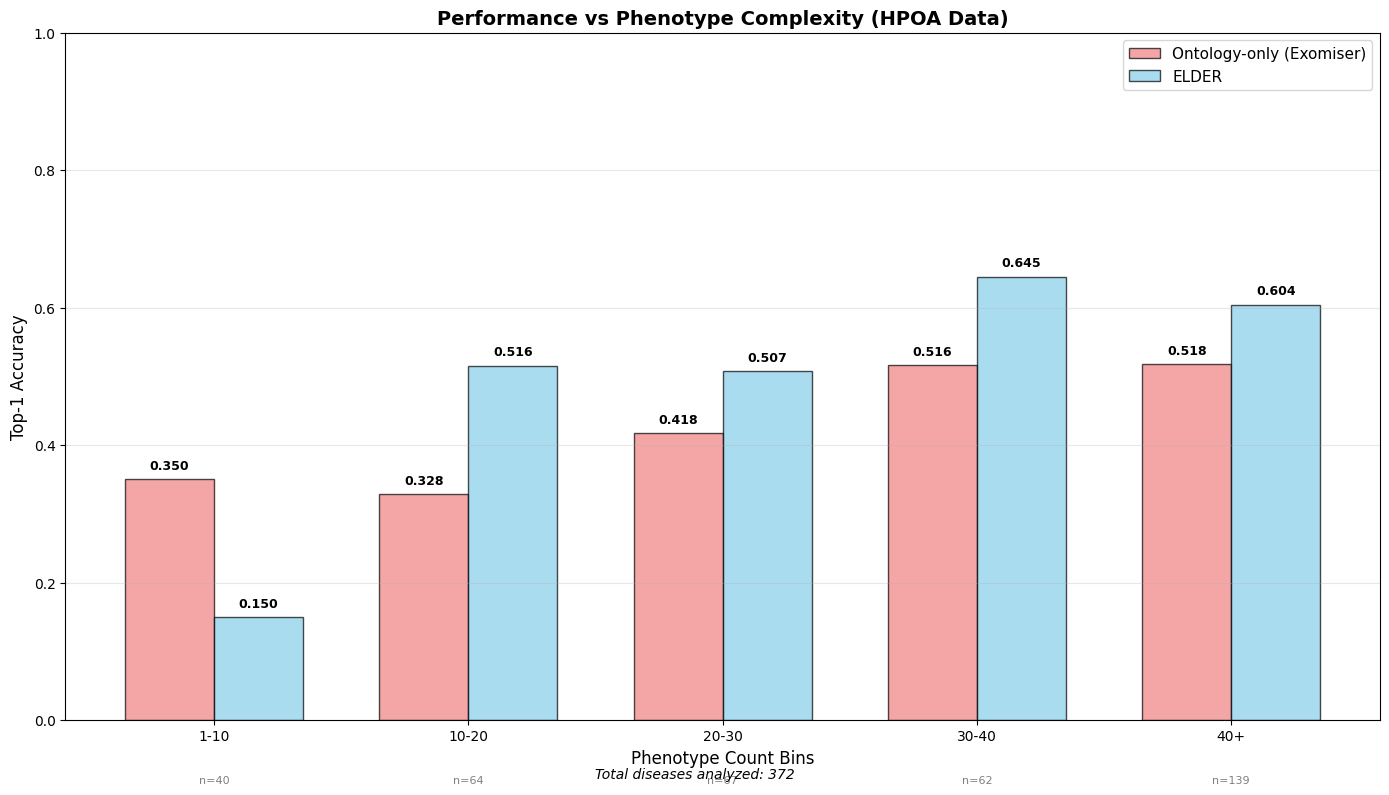


Overall Performance Summary:
  ELDER average: 0.485
  Ontology-only average: 0.426
  Difference: +0.058 (ELDER better)
  Bins with data: 5/5


In [20]:
def create_phenotype_complexity_plot(binned_data, save_plots=True):
    """
    Create a bar chart showing accuracy by phenotype complexity bins.
    
    Parameters:
        binned_data: Dictionary mapping bin names to DataFrames
        save_plots: Whether to save the plots to files
    """
    if not binned_data:
        print("No data to plot!")
        return
    
    plt.figure(figsize=(14, 8))
    
    # Prepare
    bin_names = list(binned_data.keys())
    elder_accuracies = []
    exomiser_accuracies = []
    bin_counts = []
    
    for bin_name in bin_names:
        bin_df = binned_data[bin_name]
        if len(bin_df) > 0:
            elder_accuracies.append(bin_df['elder_top1'].mean())
            exomiser_accuracies.append(bin_df['exomiser_top1'].mean())
            bin_counts.append(len(bin_df))
        else:
            elder_accuracies.append(0)
            exomiser_accuracies.append(0)
            bin_counts.append(0)
    
    # plot
    x = np.arange(len(bin_names))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, exomiser_accuracies, width, label='Ontology-only (Exomiser)', 
                   color='lightcoral', edgecolor='black', alpha=0.7)
    bars2 = plt.bar(x + width/2, elder_accuracies, width, label='ELDER', 
                   color='skyblue', edgecolor='black', alpha=0.7)
    
    plt.xlabel('Phenotype Count Bins', fontsize=12)
    plt.ylabel('Top-1 Accuracy', fontsize=12)
    plt.title('Performance vs Phenotype Complexity (HPOA Data)', fontsize=14, fontweight='bold')
    plt.ylim(0, 1.0)
    plt.xticks(x, bin_names)
    plt.legend(fontsize=11)
    
    # Add value labels on bars
    for i, (bar1, bar2, count) in enumerate(zip(bars1, bars2, bin_counts)):
        if count > 0:  # Only label bars with data
            plt.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height() + 0.01,
                    f'{exomiser_accuracies[i]:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
            plt.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height() + 0.01,
                    f'{elder_accuracies[i]:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
        
        # Add count labels below bars
        plt.text(i, -0.08, f'n={count}', ha='center', va='top', fontsize=8, color='gray')
    
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    
    # Add footer with total diseases
    total_diseases = sum(bin_counts)
    plt.figtext(0.5, 0.02, f'Total diseases analyzed: {total_diseases}', ha='center', fontsize=10, style='italic')
    
    if save_plots:
        svg_path = RESULTS_DIR / 'figure_5_performance_as_func_of_nr_of_pheno_p_disease.svg'
        png_path = RESULTS_DIR / 'figure_5_performance_as_func_of_nr_of_pheno_p_disease.png'
        
        plt.savefig(svg_path, bbox_inches='tight')
        plt.savefig(png_path, dpi=300, bbox_inches='tight')
        
        print(f"\nPlots saved:")
        print(f"  SVG: {svg_path}")
        print(f"  PNG: {png_path}")
    
    plt.show()
    
    # Calculate overall statistics
    non_empty_bins = [(name, elder_accuracies[i], exomiser_accuracies[i]) 
                     for i, name in enumerate(bin_names) if bin_counts[i] > 0]
    
    if non_empty_bins:
        avg_elder = np.mean([acc for _, acc, _ in non_empty_bins])
        avg_exomiser = np.mean([acc for _, _, acc in non_empty_bins])
        difference = avg_elder - avg_exomiser
        
        print(f"\nOverall Performance Summary:")
        print(f"  ELDER average: {avg_elder:.3f}")
        print(f"  Ontology-only average: {avg_exomiser:.3f}")
        print(f"  Difference: {difference:+.3f} ({'ELDER better' if difference > 0 else 'Ontology-only better'})")
        print(f"  Bins with data: {len(non_empty_bins)}/{len(bin_names)}")

create_phenotype_complexity_plot(binned_diseases, save_plots=True)

## Summary Statistics

Let's generate some summary statistics about our analysis:

In [21]:
def generate_summary_statistics(disease_table, binned_diseases):
    """
    Generate comprehensive summary statistics.
    """
    if len(disease_table) == 0:
        print("No data available for summary statistics.")
        return
    
    print("=" * 60)
    print("FIGURE 5 ANALYSIS SUMMARY")
    print("=" * 60)
    
    print(f"\nData Sources:")
    print(f"  HPOA file: phenotype.hpoa")
    print(f"  Database: Best_Match_Cosine_all_combined_Elder_vs_Exomiser.db")
    print(f"  Total diseases analyzed: {len(disease_table)}")
    
    print(f"\nPhenotype Complexity Distribution:")
    phenotype_counts = disease_table['phenotype_count'].values
    print(f"  Min phenotypes: {phenotype_counts.min()}")
    print(f"  Max phenotypes: {phenotype_counts.max()}")
    print(f"  Mean phenotypes: {phenotype_counts.mean():.1f}")
    print(f"  Median phenotypes: {np.median(phenotype_counts):.1f}")
    
    print(f"\nOverall Performance:")
    elder_overall = disease_table['elder_top1'].mean()
    exomiser_overall = disease_table['exomiser_top1'].mean()
    print(f"  ELDER Top-1 Accuracy: {elder_overall:.3f}")
    print(f"  Exomiser Top-1 Accuracy: {exomiser_overall:.3f}")
    print(f"  ELDER Advantage: {elder_overall - exomiser_overall:+.3f}")
    
    print(f"\nBin-wise Analysis:")
    for bin_name, bin_df in binned_diseases.items():
        if len(bin_df) > 0:
            elder_acc = bin_df['elder_top1'].mean()
            exomiser_acc = bin_df['exomiser_top1'].mean()
            advantage = elder_acc - exomiser_acc
            print(f"  {bin_name:>6}: n={len(bin_df):>3}, ELDER={elder_acc:.3f}, Exomiser={exomiser_acc:.3f}, Diff={advantage:+.3f}")

generate_summary_statistics(disease_table, binned_diseases)

FIGURE 5 ANALYSIS SUMMARY

Data Sources:
  HPOA file: phenotype.hpoa
  Database: Best_Match_Cosine_all_combined_Elder_vs_Exomiser.db
  Total diseases analyzed: 372

Phenotype Complexity Distribution:
  Min phenotypes: 2
  Max phenotypes: 183
  Mean phenotypes: 37.4
  Median phenotypes: 33.0

Overall Performance:
  ELDER Top-1 Accuracy: 0.530
  Exomiser Top-1 Accuracy: 0.449
  ELDER Advantage: +0.081

Bin-wise Analysis:
    1-10: n= 40, ELDER=0.150, Exomiser=0.350, Diff=-0.200
   10-20: n= 64, ELDER=0.516, Exomiser=0.328, Diff=+0.188
   20-30: n= 67, ELDER=0.507, Exomiser=0.418, Diff=+0.090
   30-40: n= 62, ELDER=0.645, Exomiser=0.516, Diff=+0.129
     40+: n=139, ELDER=0.604, Exomiser=0.518, Diff=+0.086


## Save Results Table

Let's save the disease complexity table for future reference:

In [22]:
# Save the disease table to CSV
if len(disease_table) > 0:
    output_csv = RESULTS_DIR / 'figure_5_performance_as_func_of_nr_of_pheno_p_disease.csv'
    disease_table.to_csv(output_csv, index=False)
    print(f"Disease complexity table saved to: {output_csv}")
    
    # Also save bin summary
    bin_summary = []
    for bin_name, bin_df in binned_diseases.items():
        if len(bin_df) > 0:
            bin_summary.append({
                'bin': bin_name,
                'count': len(bin_df),
                'elder_accuracy': bin_df['elder_top1'].mean(),
                'exomiser_accuracy': bin_df['exomiser_top1'].mean(),
                'elder_advantage': bin_df['elder_top1'].mean() - bin_df['exomiser_top1'].mean()
            })
    
    if bin_summary:
        bin_summary_df = pd.DataFrame(bin_summary)
        bin_csv = RESULTS_DIR / 'figure_5_performance_as_func_of_nr_of_pheno_p_disease_bin_summary.csv'
        bin_summary_df.to_csv(bin_csv, index=False)
        print(f"Bin summary saved to: {bin_csv}")
        
        print(f"\nBin Summary:")
        print(bin_summary_df.to_string(index=False))
else:
    print("No data to save.")

Disease complexity table saved to: ../results/figure_5_performance_as_func_of_nr_of_pheno_p_disease.csv
Bin summary saved to: ../results/figure_5_performance_as_func_of_nr_of_pheno_p_disease_bin_summary.csv

Bin Summary:
  bin  count  elder_accuracy  exomiser_accuracy  elder_advantage
 1-10     40        0.150000           0.350000        -0.200000
10-20     64        0.515625           0.328125         0.187500
20-30     67        0.507463           0.417910         0.089552
30-40     62        0.645161           0.516129         0.129032
  40+    139        0.604317           0.517986         0.086331
